# A Deep Learning-Based Model for Diabetic Retinopathy Grading 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import datasets, models
from torchvision.models import resnet50, ResNet50_Weights, EfficientNet_B0_Weights, ResNet101_Weights, ResNet18_Weights, ResNet34_Weights, MobileNet_V2_Weights, DenseNet121_Weights
import torchvision.transforms as transforms
import optuna
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import os
import timm
from torch.amp import GradScaler, autocast
from sklearn.metrics import cohen_kappa_score
from timm.models import create_model
from enlighten_inference import EnlightenOnnxModel
tqdm.pandas()

Dataset URL - https://www.kaggle.com/datasets/ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy

## Dataset Loading

In [4]:
# Reading the dataset excel and renaming the columns
df = pd.read_excel("./data/dr_unified_dataset_Good_Useable_reduced.xlsx")
df = df[['Img_Path', 'Retinopathy_grade', 'Split']]

In [5]:
df["Retinopathy_grade"].value_counts()

Retinopathy_grade
1    2110
2    2051
0    2048
4     595
3     520
Name: count, dtype: int64

In [6]:
# This function is to load the images from the image path present in the excel
def load_image(image_path, label, split):
    full_path = f"./data/dr_unified_v2/{split}/{label}/{image_path}"
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Image file not found: {full_path}")
    img = cv2.imread(full_path)
    if img is None:
        raise ValueError(f"Failed to read image: {full_path}")
    return img

In [7]:
df["Img_Array"] = df.apply(lambda row: load_image(row["Img_Path"], row["Retinopathy_grade"], row['Split']), axis=1)

In [8]:
df.head()

,Img_Path,Retinopathy_grade,Split,Img_Array
0,00cc2b75cddd.jpg,0,train,"[[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], ..."
1,00f6c1be5a33.jpg,0,train,"[[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], ..."
2,0125fbd2e791.jpg,0,train,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
3,0151781fe50b.jpg,0,train,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,0182152c50de.jpg,0,train,"[[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], ..."


## Preprocessing

In [9]:
# Selecting a Sample Image to show the results of preprocessing
img_name = "00cc2b75cddd.jpg"
img_test = df.loc[df['Img_Path'] == img_name, 'Img_Array'].iloc[0]

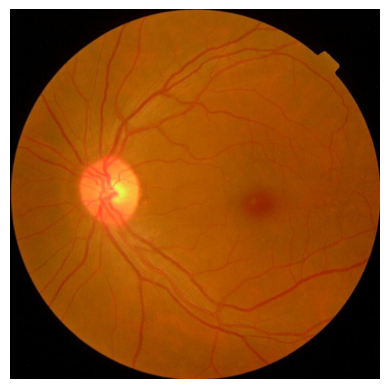

In [10]:
# Display Image using Matplotlib
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.axis("off") 
plt.show()

### Circle Crop

In [11]:
# Function to crop the excessive black background present in the image
def crop_eye_region(img):
    
    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Apply thresholding to create a binary image
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Step 3: Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 4: Find the largest contour
    max_contour = max(contours, key=cv2.contourArea)
    
    # Step 5: Get bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(max_contour)
    
    # Step 6: Crop the eye region (ROI)
    cropped_img = img[y:y+h, x:x+w]

    
    return cropped_img

In [12]:
cropped_image = crop_eye_region(img_test)

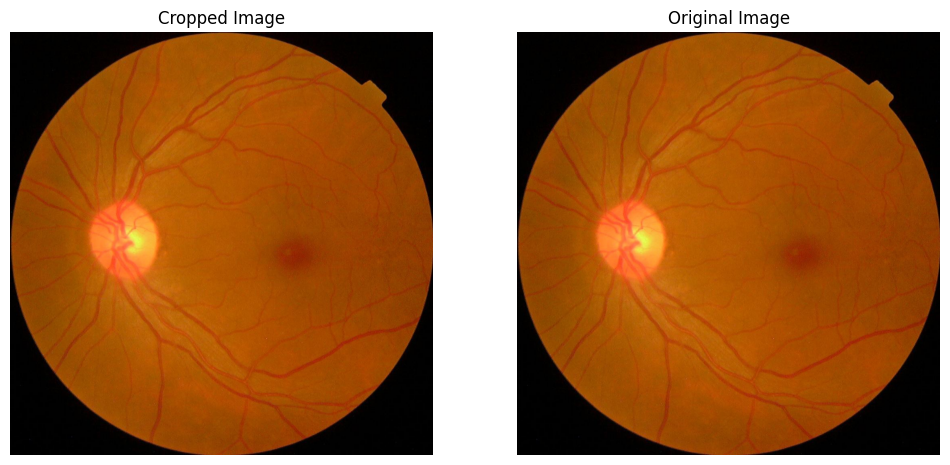

In [13]:
# Display the Before and After Image for this preprocessing step.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))  
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))  
plt.title("Cropped Image")
plt.axis('off')

plt.show()

### Resizing the image

In [14]:
# This function is used to resize the image without skewing the image due to change in aspect ratio
def resize_and_pad(image, size=512, pad_color=0):
    h, w = image.shape[:2]

    # Calculate scale to preserve aspect ratio
    scale = size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculate padding amounts
    pad_w = size - new_w
    pad_h = size - new_h
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    # Add padding
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                borderType=cv2.BORDER_CONSTANT,
                                value=pad_color)
    return padded

In [15]:
resized_img = resize_and_pad(cropped_image)

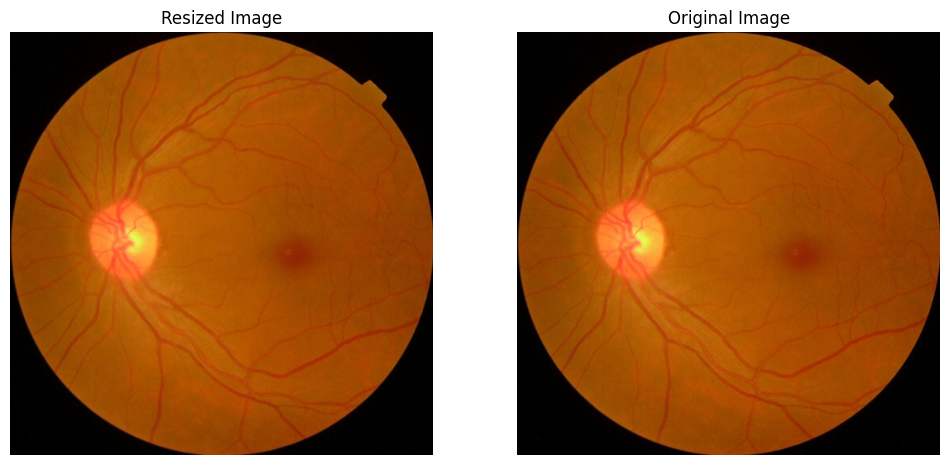

In [16]:
# Display the Before and After Image for this preprocessing step.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))  
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))  
plt.title("Resized Image")
plt.axis('off')

plt.show()

### Ligthing model

In [17]:
# Using the Enligthen GAN model to enchance the ligthing of the image.
model = EnlightenOnnxModel()
resized_image_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

gan_img = model.predict(resized_image_rgb)

gan_img_image_bgr = cv2.cvtColor(gan_img, cv2.COLOR_RGB2BGR)

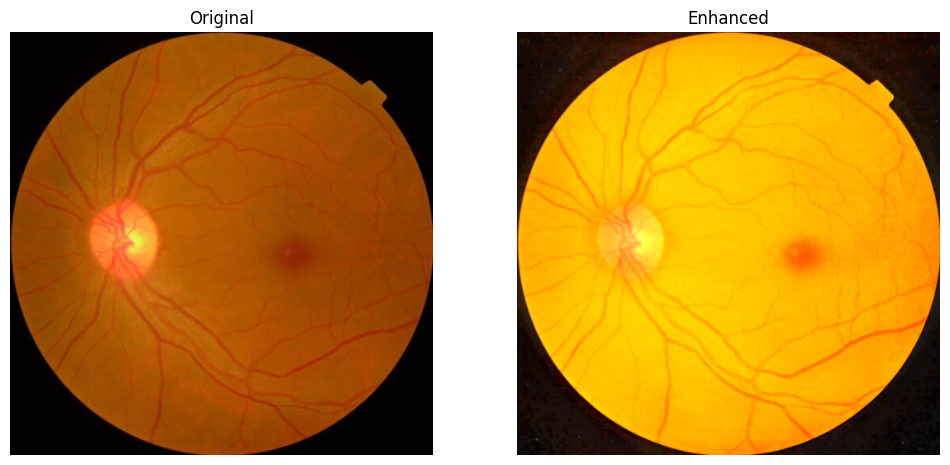

In [18]:
# Display the Before and After Image for this preprocessing step.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Enhanced')
# plt.imshow(cv2.cvtColor(gan_img_image_bgr, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(gan_img_image_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Clahe Preprocessing

In [19]:
# This function applies CLAHE to the Green channel of the image and merges it back into RGB
def clahe_preprocessing(img):
    green_channel = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    green_clahe = clahe.apply(green_channel)
    clahe_rgb = img.copy()
    clahe_rgb[:, :, 1] = green_clahe
    return clahe_rgb
   

In [20]:
clahe_image = clahe_preprocessing(gan_img_image_bgr)

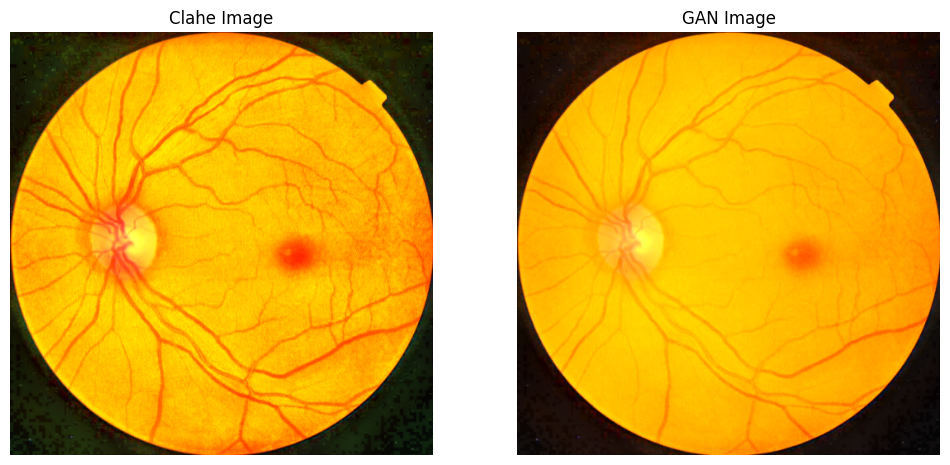

In [21]:
# Display the Before and After Image for this preprocessing step.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gan_img_image_bgr, cv2.COLOR_BGR2RGB))
plt.title("GAN Image")
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))  
plt.title("Clahe Image")
plt.axis('off')

plt.show()

### Combined preprocessing function:

In [22]:
# This function applies all the preprocessing steps
def preprocess_crop_resize_image(image):
    cropped_image = crop_eye_region(image)
    resized_img = resize_and_pad(cropped_image)
    model = EnlightenOnnxModel()
    gan_img = model.predict(resized_img)   
    clahe_image = clahe_preprocessing(gan_img) 
    return clahe_image

In [23]:
df["Img_Array"] = df["Img_Array"].progress_apply(preprocess_crop_resize_image)

100%|██████████| 7324/7324 [22:24<00:00,  5.45it/s]


In [24]:
# Here I am saving the preprocessed Images
save_dir = './data/preprocessed_images_combined'
os.makedirs(save_dir, exist_ok=True)

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Saving images"):
    img = row['Img_Array']
    name = os.path.splitext(os.path.basename(row['Img_Path']))[0] + '.jpeg'
    save_path = os.path.join(save_dir, name)

    # Save the image
    cv2.imwrite(save_path, img)

Saving images: 100%|██████████| 7324/7324 [00:28<00:00, 256.04it/s]


## Train Test Split

In [25]:
# Reading the Image excel again if you want to directly start with preprocessed Images
df = pd.read_excel("./data/dr_unified_dataset_Good_Useable_reduced.xlsx")
df = df[['Img_Path', 'Retinopathy_grade']]

In [26]:
df['Retinopathy_grade'] = df['Retinopathy_grade'].replace({1: 1, 2: 1, 3: 2, 4: 2, 0: 0})

In [27]:
df['Retinopathy_grade'].value_counts()

Retinopathy_grade
1    4161
0    2048
2    1115
Name: count, dtype: int64

In [28]:
# Function to load the preprocessed images from the image names present in excel.
def load_image(image_path):
    image_name = os.path.splitext(image_path)[0]
    full_path = f"./data/preprocessed_images_combined/{image_name}.jpeg"
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Image file not found: {full_path}")
    img = cv2.imread(full_path)
    if img is None:
        raise ValueError(f"Failed to read image: {full_path}")
    return img

df["Img_Array"] = df["Img_Path"].apply(load_image)

In [29]:
# Splitting the Dataset into train and test sets. Ratio is 70:30 (Train:Test)
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["Retinopathy_grade"]
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


print("Train Distribution")
print(train_df["Retinopathy_grade"].value_counts())
print("")
print("Test Distribution")
print(test_df["Retinopathy_grade"].value_counts())
print("")

Train Distribution
Retinopathy_grade
1    2912
0    1433
2     781
Name: count, dtype: int64

Test Distribution
Retinopathy_grade
1    1249
0     615
2     334
Name: count, dtype: int64



## Data Augmentation

In [30]:
# This is the Function to augment the images.
def augment_image(image):
    """
    Augment a single BGR image (post-Ben Graham preprocessing) using:
    - Random rotation (±10 degrees)
    - Random flip (no flip / horizontal / vertical)
    - Slight zoom in/out (scale between 0.9 and 1.1)
    - Add small Gaussian noise
    """
    height, width = image.shape[:2]

    # 1. Random rotation
    rotation_angle = random.uniform(-10, 10)
    matrix = cv2.getRotationMatrix2D((width / 2, height / 2), rotation_angle, 1)
    image = cv2.warpAffine(image, matrix, (width, height), borderMode=cv2.BORDER_REFLECT101)

    # 2. Random flip: no flip (0), horizontal (1), vertical (0) or both (-1)
    flip_type = random.choice([-1, 0, 1])
    image = cv2.flip(image, flip_type)

    # 3. Slight zoom in/out
    scale = random.uniform(0.9, 1.1)
    new_width, new_height = int(width * scale), int(height * scale)
    # Resize then crop or pad back to original size
    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    if scale < 1.0:
        # Pad resized image to original size
        pad_w = (width - new_width) // 2
        pad_h = (height - new_height) // 2
        image = cv2.copyMakeBorder(resized, pad_h, height - new_height - pad_h, pad_w, width - new_width - pad_w,
                                   borderType=cv2.BORDER_REFLECT101)
    else:
        # Crop center
        start_x = (new_width - width) // 2
        start_y = (new_height - height) // 2
        image = resized[start_y:start_y + height, start_x:start_x + width]

    # 4. Add small Gaussian noise
    noise_std = 5  # Adjust noise level here, 5 is low intensity
    noise = np.random.normal(0, noise_std, image.shape).astype(np.float32)
    image = image.astype(np.float32) + noise
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image


In [31]:
# Selecting a Sample Image to show the results of preprocessing

img_test = train_df["Img_Array"][0]

aug_img = augment_image(img_test)

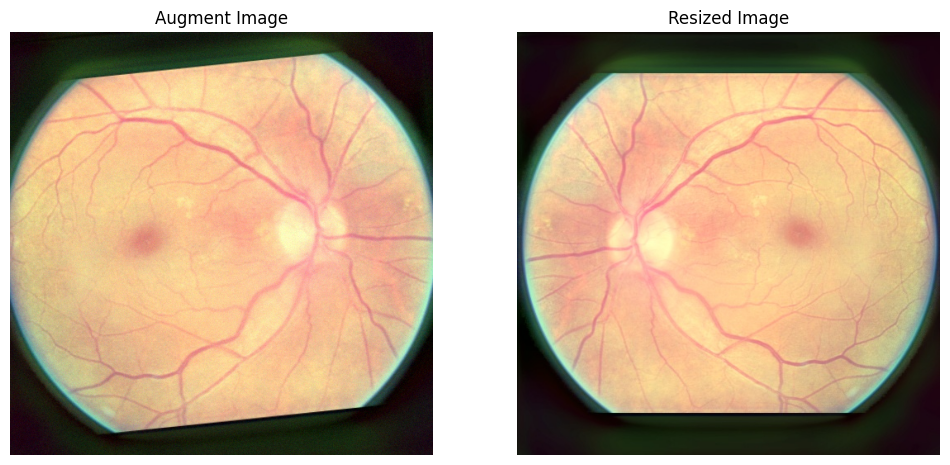

In [32]:
# Display the Before and After Image for this preprocessing step.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))  
plt.title("Resized Image")
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))  
plt.title("Augment Image")
plt.axis('off')

# Show the plot
plt.show()

In [33]:
# This function is used to upscale the minority classes, by applying augmentation to existing image to get new samples.
def augment_class(images, target_count):
    """ Augment images for a specific class until the target count is reached. """
    augmented_images = []
    while len(images) < target_count:
        for image in images:
            augmented_image = augment_image(image)
            augmented_images.append(augmented_image)
            if len(augmented_images) + len(images) >= target_count:
                break
        if len(augmented_images) + len(images) >= target_count:
            break
    return augmented_images

In [34]:
train_target_counts_3stage = {
    0: 2900,  # Grade 0
    1: 2900,  # Grade 1
    2: 2900  # Grade 2
}

test_target_counts_3stage = {
    0: 1200,  # Grade 0
    1: 1200,  # Grade 1
    2: 1200   # Grade 2
}

In [35]:
# This function create a new DataFrame consisting the existing and augmented Images.
def augment_dataframe(df, target_counts):
    """ Augment the images in the DataFrame based on the target counts. """
    augmented_data = []

    # Add tqdm for progress on class-level augmentation
    for label in tqdm(df['Retinopathy_grade'].unique(), desc="Augmenting by grade"):
        # Extract images and labels for the current grade
        class_images = df[df['Retinopathy_grade'] == label]['Img_Array'].tolist()

        # Get the target count for the current grade
        target_count = target_counts.get(label, len(class_images))

        # Augment images to the target count
        augmented_images = augment_class(class_images, target_count)

        # Add augmented images to the final augmented dataset
        augmented_data.extend([(image, label) for image in augmented_images])

    # Convert augmented data into a DataFrame
    augmented_df = pd.DataFrame(augmented_data, columns=['Img_Array', 'Retinopathy_grade'])

    # Append augmented data to the original DataFrame
    df_augmented = pd.concat([df, augmented_df], ignore_index=True)

    return df_augmented

In [36]:
# Here, I am only retaining the Image and its DR Grade
train_df = train_df[["Img_Array", "Retinopathy_grade"]]
test_df = test_df[["Img_Array", "Retinopathy_grade"]]



In [37]:
train_df.head()

,Img_Array,Retinopathy_grade
0,"[[[7, 18, 8], [9, 20, 10], [10, 20, 14], [10, ...",0
1,"[[[6, 18, 6], [11, 23, 11], [15, 23, 16], [13,...",1
2,"[[[6, 18, 6], [10, 22, 10], [13, 24, 16], [11,...",1
3,"[[[7, 17, 5], [8, 18, 6], [11, 18, 11], [12, 1...",1
4,"[[[4, 18, 6], [9, 23, 11], [13, 24, 16], [11, ...",1


In [38]:
test_df.head()

,Img_Array,Retinopathy_grade
0,"[[[5, 19, 8], [6, 20, 9], [10, 20, 14], [10, 2...",1
1,"[[[6, 19, 5], [8, 21, 7], [11, 20, 10], [10, 1...",0
2,"[[[8, 19, 9], [11, 22, 12], [15, 22, 17], [15,...",1
3,"[[[5, 19, 8], [8, 22, 11], [14, 25, 17], [14, ...",1
4,"[[[10, 21, 11], [12, 23, 13], [16, 24, 17], [1...",1


In [39]:
# Augmenting the train dataset
train_df = augment_dataframe(train_df, train_target_counts_3stage)

Augmenting by grade: 100%|██████████| 3/3 [01:38<00:00, 32.72s/it]


In [40]:
# Augmenting the test dataset
test_df = augment_dataframe(test_df, test_target_counts_3stage)

Augmenting by grade: 100%|██████████| 3/3 [00:35<00:00, 11.90s/it]


In [41]:
# We are separately augmenting the train and test set to avoid data leakage from train set to test set.
print("New Train counts after 4-stage augmentation:")
print(train_df['Retinopathy_grade'].value_counts())

print("New Test counts after 4-stage augmentation:")
print(test_df['Retinopathy_grade'].value_counts())

New Train counts after 4-stage augmentation:
Retinopathy_grade
1    2912
0    2900
2    2900
Name: count, dtype: int64
New Test counts after 4-stage augmentation:
Retinopathy_grade
1    1249
0    1200
2    1200
Name: count, dtype: int64


## Model Training Helper 

In [42]:
class RetinopathyDataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.labels = labels
        self.images = images
        self.augment = augment
        
        # Light augmentations to apply dynamically during training
        self.augmentations = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                                 std=[0.229, 0.224, 0.225]),
        ])
        
        # For validation/test (no augmentation)
        self.base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert BGR (OpenCV) to RGB
        image = image[:, :, ::-1].copy() 

        if self.augment:
            # Apply light augmentations during training
            image = self.augmentations(image)
        else:
            # Validation/test transformations only
            image = self.base_transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


In [43]:
def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validating", leave=False)
        for img, label in progress_bar:
            img, label = img.to(device), label.to(device)

            with autocast(device_type=device.type):  
                outputs = model(img)
                loss = criterion(outputs, label)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

            # Optional: update progress bar with loss
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {val_acc:.4f}, QWK: {val_qwk:.4f}")
    return avg_loss, val_acc, val_qwk

In [44]:
def train_model(model, device, train_loader, dev_loader, optimizer, criterion, epochs=10):
    model.to(device)
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_loss = float("inf")
    best_model = None
    counter = 0
    train_loss_lst = []
    train_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        all_preds = []
        all_labels = []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for step, (img, label) in enumerate(progress_bar):
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()
            with autocast(device_type=device.type):  # AMP: autocast context
                outputs = model(img)
                loss = criterion(outputs, label)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # Save predictions and true labels
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        train_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        train_acc = accuracy_score(all_labels, all_preds)
        train_loss_lst.append(avg_loss)
        train_acc_lst.append(train_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:4f}, Train QWK: {train_qwk:.4f}, LR: {optimizer.param_groups[0]['lr']}")

        # Validate and update LR scheduler
        val_loss, val_acc, _ = validate(model, device, dev_loader, criterion)
        val_loss_lst.append(val_loss)
        val_acc_lst.append(val_acc)
        
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model, "model.pt")
            best_model = model
            counter = 0
        else:
            counter += 1

        if counter >= 10:
            print("Early stopping triggered.")
            break

    return best_model, train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst


In [45]:
def evaluate(model, device, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Quadratic Weighted Kappa: {qwk:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    labels = ["No DR", "Mild & Moderate", "Severe & Proliferative"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Best Model")
    plt.grid(False)
    plt.show()

In [46]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Can be a list for class balancing
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

## Model

In [47]:
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class DRClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.4):
        super(DRClassifier, self).__init__()

        # Load stronger pretrained backbone
        self.base_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        self.features = self.base_model.features

        # Optional lightweight attention block
        self.attention = nn.Sequential(
            nn.Conv2d(1280, 1280, kernel_size=1),
            nn.BatchNorm2d(1280),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(1280, 1280, 1),
            nn.Sigmoid()
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        attn = self.attention(x)
        x = x * attn
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [48]:
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoches = 10

model = DRClassifier()

# Move model to GPU (if available)
model = model.to(device)

train_dataset = RetinopathyDataset(images=train_df["Img_Array"], labels=train_df["Retinopathy_grade"], augment=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RetinopathyDataset(images=test_df["Img_Array"], labels=test_df["Retinopathy_grade"])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Model Training Function

In [49]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = FocalLoss(gamma=2.0, alpha=None)

In [50]:
best_model, train_loss_lst, train_acc_lst, test_loss_lst, test_acc_lst = train_model(model, device, train_dataloader, test_dataloader, optimizer, criterion, epoches)


Epoch 1/10, Train Loss: 0.2027, Train Acc: 0.729454, Train QWK: 0.6759, LR: 0.0001


Validation Loss: 0.1247, Accuracy: 0.7945, QWK: 0.7935


Epoch 2/10, Train Loss: 0.1418, Train Acc: 0.785927, Train QWK: 0.7793, LR: 0.0001


Validation Loss: 0.1143, Accuracy: 0.8068, QWK: 0.8222


Epoch 3/10, Train Loss: 0.1209, Train Acc: 0.808196, Train QWK: 0.8168, LR: 0.0001


Validation Loss: 0.1124, Accuracy: 0.8115, QWK: 0.8160


Epoch 4/10, Train Loss: 0.1077, Train Acc: 0.816230, Train QWK: 0.8315, LR: 0.0001


Validation Loss: 0.1139, Accuracy: 0.7947, QWK: 0.7974


Epoch 5/10, Train Loss: 0.1008, Train Acc: 0.828053, Train QWK: 0.8459, LR: 0.0001


Validation Loss: 0.1142, Accuracy: 0.8084, QWK: 0.8280


Epoch 6/10, Train Loss: 0.0911, Train Acc: 0.844123, Train QWK: 0.8668, LR: 0.0001


Validation Loss: 0.1122, Accuracy: 0.8202, QWK: 0.8344


Epoch 7/10, Train Loss: 0.0845, Train Acc: 0.854568, Train QWK: 0.8789, LR: 0.0001


Validation Loss: 0.1294, Accuracy: 0.8057, QWK: 0.8092


Epoch 8/10, Train Loss: 0.0814, Train Acc: 0.859619, Train QWK: 0.8857, LR: 0.0001


Validation Loss: 0.1209, Accuracy: 0.8169, QWK: 0.8249


Epoch 9/10, Train Loss: 0.0740, Train Acc: 0.871556, Train QWK: 0.8975, LR: 0.0001


Validation Loss: 0.1053, Accuracy: 0.8276, QWK: 0.8498


Epoch 10/10, Train Loss: 0.0719, Train Acc: 0.875574, Train QWK: 0.8986, LR: 0.0001


Validation Loss: 0.1172, Accuracy: 0.8213, QWK: 0.8425


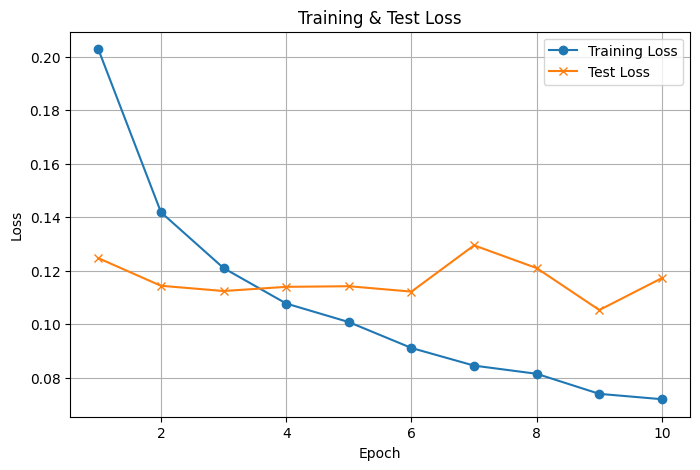

In [51]:
epochs = range(1, len(train_loss_lst)+ 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss_lst, label='Training Loss', marker='o')
plt.plot(epochs, test_loss_lst, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Test Loss')
plt.legend()
plt.grid(True)
plt.show()

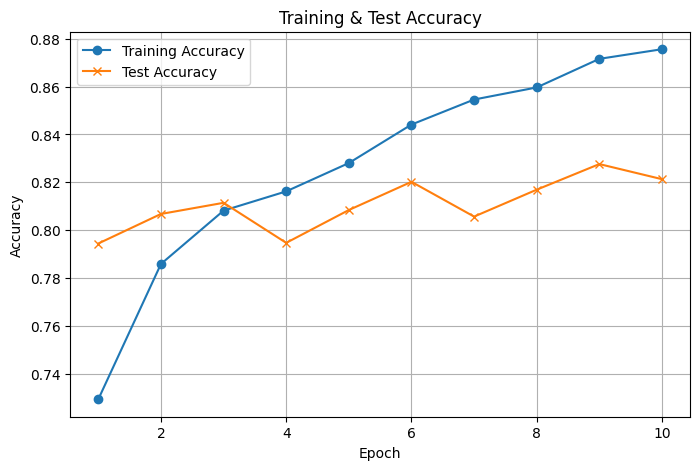

In [52]:
epochs = range(1, len(train_acc_lst)+ 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc_lst, label='Training Accuracy', marker='o')
plt.plot(epochs, test_acc_lst, label='Test Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Evaluating:   0%|          | 0/1089 [00:00<?, ?it/s]

Test Accuracy: 0.9129
Test Quadratic Weighted Kappa: 0.9365


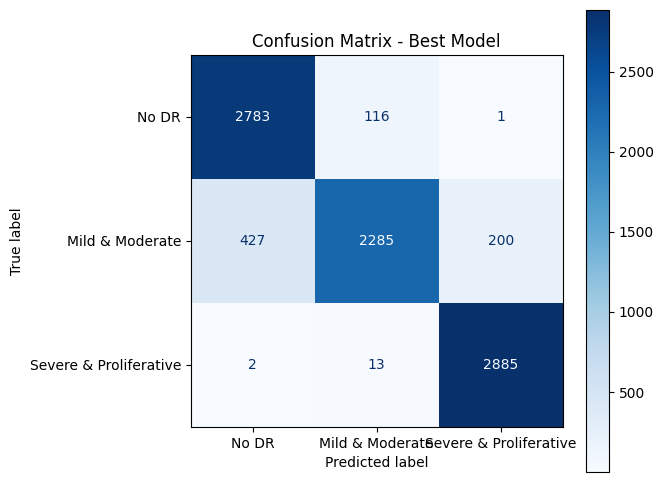

In [53]:
evaluate(best_model, device, train_dataloader)

Test Accuracy: 0.8210
Test Quadratic Weighted Kappa: 0.8423


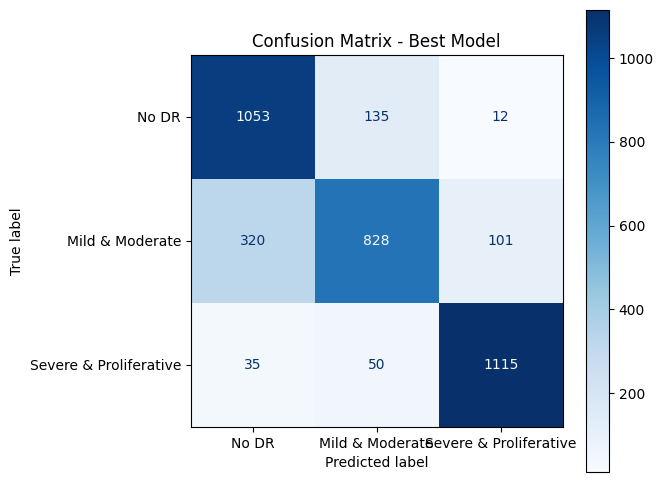

In [54]:
evaluate(best_model, device, test_dataloader)